In [1]:
import os
import glob
import shutil
from matplotlib import projections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "../GIT/colmap/scripts/python")
from database import COLMAPDatabase
from scipy.spatial.transform import Rotation

In [2]:
dir = './images'
# Check whether the specified path exists or not
if not os.path.exists(dir):
    os.mkdir(dir)
# remove all files in downsampled dir
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

mypath = './monopointcloud/'
files = glob.glob(mypath + '*/semseg/*')
cameras = glob.glob(mypath + '*/camera.txt')
files.sort()
cameras.sort()
length = len(files)

# Constructiong data frames
colmap_imgs = pd.read_csv("./sparse/model/images.txt", sep=' ', comment='#', 
                          names=['image_id', 'qw', 'qx', 'qy', 'qz', 'tx', 'ty', 'tz', 'camera_id', 'name'])
mp_cams = pd.DataFrame()
for c in cameras:
    mp_cams = pd.concat([mp_cams, pd.read_csv(c, sep=' ', 
                                              names=['x', 'y', 'z', 'pitch', 'yaw', 'roll'])])

mp_cams['img_file'] = files

In [3]:
# angle conversions
#euler_angles = np.array([mp_cams.roll, mp_cams.pitch, mp_cams.yaw]).transpose()
euler_angles = np.array([mp_cams.yaw, mp_cams.pitch, mp_cams.roll]).transpose()
#r = Rotation.from_euler('ZYX', euler_angles, degrees=True)
r = Rotation.from_euler('xyz', euler_angles, degrees=True)
mp_cams['qx'], mp_cams['qy'], mp_cams['qz'], mp_cams['qw'] \
    = r.as_quat().transpose()


In [4]:
# rotate then translate
dirs_x = np.zeros((len(mp_cams), 3))
dirs_x[:, 1] = 1 #-1 need to flip over because the Z axis is inverted in translation

dirs_y = np.zeros((len(mp_cams), 3))
dirs_y[:, 2] = 1 #-1 need to flip over because the Z axis is inverted in translation

dirs_z = np.zeros((len(mp_cams), 3))
dirs_z[:, 0] = 1

origo = mp_cams.loc[:, ['x', 'y', 'z']].to_numpy()

dirs_x = r.apply(dirs_x)
dirs_y = r.apply(dirs_y)
dirs_z = r.apply(dirs_z)
origo = r.apply(origo)

mp_cams['dx1'], mp_cams['dx2'], mp_cams['dx3'] = dirs_x.transpose()
mp_cams['dy1'], mp_cams['dy2'], mp_cams['dy3'] = dirs_y.transpose()
mp_cams['dz1'], mp_cams['dz2'], mp_cams['dz3'] = dirs_z.transpose()

mp_cams['ox'], mp_cams['oy'], mp_cams['oz'] = origo.transpose()

In [28]:
# translate then rotate
origo = mp_cams.loc[:, ['x', 'y', 'z']].to_numpy()

dirs_x = np.zeros((len(mp_cams), 3))
dirs_x[:, 1] = 1
dirs_x = origo + dirs_x

dirs_y = np.zeros((len(mp_cams), 3))
dirs_y[:, 2] = 1
dirs_y = origo + dirs_y

dirs_z = np.zeros((len(mp_cams), 3))
dirs_z[:, 0] = 1
dirs_z = origo + dirs_z

dirs_x = r.apply(dirs_x)
dirs_y = r.apply(dirs_y)
dirs_z = r.apply(dirs_z)
origo = r.apply(origo)

mp_cams['dx1'], mp_cams['dx2'], mp_cams['dx3'] = (dirs_x - origo).transpose()
mp_cams['dy1'], mp_cams['dy2'], mp_cams['dy3'] = (dirs_y - origo).transpose()
mp_cams['dz1'], mp_cams['dz2'], mp_cams['dz3'] = (dirs_z - origo).transpose()

mp_cams['ox'], mp_cams['oy'], mp_cams['oz'] = origo.transpose()

In [29]:
# matrix conversion for the orientation to be ok
R = r.as_matrix()
R_ = R
R_ = -np.transpose(np.linalg.inv(R), axes=(0, 2, 1)) # adaptation of R matrix
T = mp_cams.loc[:, ['x', 'y', 'z']].to_numpy()
T = np.expand_dims(T, axis=2)
T = np.matmul(np.linalg.inv(R), T) # adaptation of T vector

mp_cams['qx'], mp_cams['qy'], mp_cams['qz'], mp_cams['qw'] \
    = Rotation.from_matrix(R_).as_quat().transpose()
mp_cams['x'], mp_cams['y'], mp_cams['z'] \
    = np.squeeze(T).transpose()

# as COLMAP

R_inv_t = np.transpose(np.linalg.inv(R_), axes=(0, 2, 1))

origo = -np.matmul(R_inv_t, T)
origo = np.squeeze(origo)

dirs_x = np.zeros((len(mp_cams), 3))
dirs_x[:, 1] = 1
dirs_x = np.expand_dims(dirs_x, axis=2)
dirs_x = T + dirs_x
dirs_x = -np.matmul(R_inv_t, dirs_x)
dirs_x = np.squeeze(dirs_x)

dirs_y = np.zeros((len(mp_cams), 3))
dirs_y[:, 2] = 1
dirs_y = np.expand_dims(dirs_y, axis=2)
dirs_y = T + dirs_y
dirs_y = -np.matmul(R_inv_t, dirs_y)
dirs_y = np.squeeze(dirs_y)

dirs_z = np.zeros((len(mp_cams), 3))
dirs_z[:, 0] = 1
dirs_z = np.expand_dims(dirs_z, axis=2)
dirs_z = T + dirs_z
dirs_z = -np.matmul(R_inv_t, dirs_z)
dirs_z = np.squeeze(dirs_z)

mp_cams['dx1'], mp_cams['dx2'], mp_cams['dx3'] = (dirs_x - origo).transpose()
mp_cams['dy1'], mp_cams['dy2'], mp_cams['dy3'] = (dirs_y - origo).transpose()
mp_cams['dz1'], mp_cams['dz2'], mp_cams['dz3'] = (dirs_z - origo).transpose()

mp_cams['ox'], mp_cams['oy'], mp_cams['oz'] = origo.transpose()

In [5]:
mp_cams['camera_id'] = 1

image_names = np.arange(0, len(mp_cams))
image_names = image_names.astype('str')
image_names = np.char.zfill(image_names, 5)
image_names = np.char.add(image_names, np.full((len(mp_cams)), '.png'))
mp_cams['image_name'] = image_names

#print(mp_cams.info())

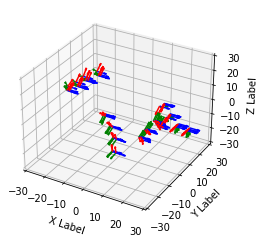

In [6]:
# Sampling
result_sample_num = 64 # we have 16 folders. This would mean 16 loops each with 32 images
ids = np.around(np.linspace(0, mp_cams.shape[0]-1, int(round(result_sample_num, 0))))
ids = ids.astype("int")

# sample and write raw image data
sample_data = mp_cams.iloc[ids].copy()

ax = plt.figure().add_subplot(projection='3d')


ax.quiver(sample_data['ox'], sample_data['oy'], sample_data['oz'], sample_data['dx1'], sample_data['dx2'], sample_data['dx3'], length=5, normalize=True, color='red')
ax.quiver(sample_data['ox'], sample_data['oy'], sample_data['oz'], sample_data['dy1'], sample_data['dy2'], sample_data['dy3'], length=5, normalize=True, color='green')
ax.quiver(sample_data['ox'], sample_data['oy'], sample_data['oz'], sample_data['dz1'], sample_data['dz2'], sample_data['dz3'], length=5, normalize=True, color='blue')

ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(-30, 30)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.savefig("./plots/test1.png", dpi=1000)

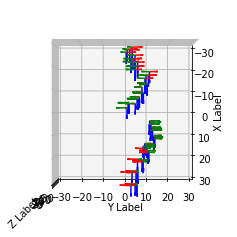

In [7]:
# Sampling
result_sample_num = 64 # we have 16 folders. This would mean 16 loops each with 32 images
ids = np.around(np.linspace(0, mp_cams.shape[0]-1, int(round(result_sample_num, 0))))
ids = ids.astype("int")

# sample and write raw image data
sample_data = mp_cams.iloc[ids].copy()

ax = plt.figure().add_subplot(projection='3d')


ax.quiver(sample_data['ox'], sample_data['oy'], sample_data['oz'], sample_data['dx1'], sample_data['dx2'], sample_data['dx3'], length=5, normalize=True, color='red')
ax.quiver(sample_data['ox'], sample_data['oy'], sample_data['oz'], sample_data['dy1'], sample_data['dy2'], sample_data['dy3'], length=5, normalize=True, color='green')
ax.quiver(sample_data['ox'], sample_data['oy'], sample_data['oz'], sample_data['dz1'], sample_data['dz2'], sample_data['dz3'], length=5, normalize=True, color='blue')

ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(-30, 30)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.view_init(azim=0, elev=90)

plt.savefig("./plots/test1.png", dpi=1000)

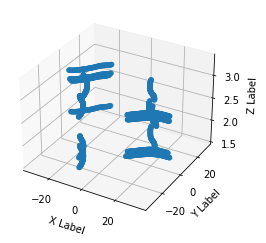

In [8]:
# Plotting 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(mp_cams.x, mp_cams.y, mp_cams.z, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.savefig("./plots/trajectory_3d.png")

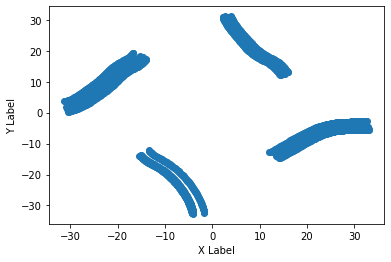

In [9]:
# Plotting 2D trajectory
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(mp_cams.x, mp_cams.y, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
plt.savefig("./plots/trajectory.png")

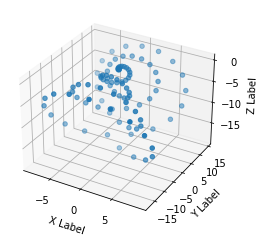

In [10]:
# Plotting 2D trajectory
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(colmap_imgs.tx, colmap_imgs.ty, colmap_imgs.tz, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.savefig("./plots/trajectory_colmap.png")

In [36]:
# Sampling
result_sample_num = 32 * 16 # we have 16 folders. This would mean 16 loops each with 32 images
ids = np.around(np.linspace(0, mp_cams.shape[0]-1, int(round(result_sample_num, 0))))
ids = ids.astype("int")

# sample and write raw image data
selected = mp_cams.iloc[ids].copy()

# copy sampled images to images folder
for index, row in selected.iterrows():
    shutil.copy(row['img_file'], dir + '/' + row['image_name'])

# IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#selected['image_id'] = np.arange(1, result_sample_num+1)

# we need the image_id to match to those in the database
db = COLMAPDatabase.connect('./database.db')
colmap_df = pd.read_sql_query("SELECT * FROM images", db)
colmap_df = colmap_df[['image_id', 'name']]

selected = selected.merge(colmap_df, how='left', left_on='image_name', right_on='name')
print(selected.head())

           x         y         z     pitch         yaw      roll  \
0  32.614223  2.763556 -1.878538 -0.000427 -179.107468  0.001708   
1  31.963635  2.773816 -1.879399 -0.001160 -179.084244  0.001216   
2  31.149592  2.787834 -1.881792 -0.002502 -179.024719  0.000915   
3  30.497657  2.800322 -1.885151 -0.003601 -178.949142  0.000813   
4  29.681759  2.818008 -1.891342 -0.005127 -178.815628  0.000765   

                              img_file        qx            qy            qz  \
0  ./monopointcloud\1_1\semseg\100.png -0.000007 -1.078600e-10  1.000000e+00   
1  ./monopointcloud\1_1\semseg\104.png -0.000020 -2.145495e-10  1.000000e+00   
2  ./monopointcloud\1_1\semseg\109.png -0.000016  1.000000e+00 -3.558208e-10   
3  ./monopointcloud\1_1\semseg\113.png -0.000015  1.000000e+00 -4.629102e-10   
4  ./monopointcloud\1_1\semseg\118.png -0.000014  1.000000e+00 -6.376852e-10   

   ...  dz1       dz2       dz3         ox        oy        oz  camera_id  \
0  ...  1.0  0.000030  0.000007  

In [37]:
# generate csv
selected = selected[['image_id', 'qw', 'qx', 'qy', 'qz', 'x', 'y', 'z', 'camera_id', 'image_name']]
selected.to_csv('./sparse/model/raw_images.csv', sep=' ', header=False, index=False)